# Convolutional Neural Network 구현

- mnist 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교 해본다.

##### 학습결과 시각화 함수 정의

In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, models

import numpy as np 
import matplotlib.pyplot as plt 

import os
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print(tf.__version__)

2.13.0


In [2]:
# 결과 시각화 함수
def plot_result(hist, loss_min=None, loss_max=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(hist.epoch, hist.history['loss'], label='Train Loss')
    plt.plot(hist.epoch, hist.history['val_loss'], label='Validation Loss')
    plt.title("Loss")
    if loss_min!=None and loss_max!=None:
        plt.ylim(loss_min, loss_max)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.epoch, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.epoch, hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# mnist CNN 적용

##### data loading

In [4]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, test_image.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
# (60000, 28, 28) -> (개수, height, width) -> channel이 없다. Convolution은 채널이 있어야한다.
# (개수, height, width, channel)

##### 전처리, Dataset 생성
- X
    - uint8을 float32 타입으로 변경.
    - pixcel값 정규화: 0 ~ 1
    - Gray scale에 channel 축이 없는 경우 dummy 축을 늘려준다.
        - 영상처리 convolution layer(Conv2D)는 입력으로 3차원 (height, width, channel) 배열을 받는다.
- Y: onehot encoding

In [12]:
a = np.array([1,2,3])
a1 = a.reshape(3,1)
print(a1) # 묶어만 주고 나머지는 dummy가 된다.
a2 = np.expand_dims(a, axis=1) # axis는 dummy축(size가 1인 축)을 어디에 늘릴지 지정.
print(a2)
a3 = a[..., np.newaxis]
print(a3)

[[1]
 [2]
 [3]]
[[1]
 [2]
 [3]]
[[1]
 [2]
 [3]]


In [14]:
# input 전처리
X_train = train_image.astype('float32')/255 # uint8 -> float32, scale을 0~1로 변경.
X_train = X_train[..., np.newaxis]# channel 축(axis)를 늘림.
# (60000, 28, 28) => (60000, 28, 28, 1)

X_test = test_image.astype('float32')/255
X_test = X_test[..., np.newaxis]

print(X_train.dtype, X_test.dtype)
print(X_train.shape, X_test.shape)

float32 float32
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [15]:
np.unique(train_label), train_label.shape

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), (60000,))

In [19]:
# output 전처리 -> OneHot Encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)


print(train_label.shape, y_train.shape)
print(test_label.shape, y_test.shape)

(60000,) (60000, 10)
(10000,) (10000, 10)


In [20]:
train_label[0]

5

In [18]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

##### 하이퍼파라미터, 변수 설정

In [21]:
LEARNING_RATE = 0.001 # 학습률
N_EPOCH = 1
N_BATCH = 1000 

N_TRAIN = X_train.shape[0] # train dataset의 개수 => shuffleDataset생성시 buffer 크기 지정할 때 사용

###### Dataset 생성

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .shuffle(N_TRAIN)\
                               .batch(N_BATCH, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)

## Model(Network) 정의
- Feature Extraction(backbone):Convolution Layer
    - block: Convolution + MaxPooling Layer
    - size(height, width) 는 줄이고 channel은 늘리는 방향으로 Layer들을 쌓는다.
    - convolution
        - size: 3 X 3
        - strides: 1
        - padding: same (입력과 출력을 동일하게 하기)
    - max pooling
        - size: 2 X 2
        - strides: 2
        - 위와 같이 지정해 input의 size를 절반으로 줄인다. 
- 분류기(Head Network)
    - Dense Layer 사용        
    - Flatten을 먼저 해야 한다. (Conv의 output-feature map- 3차원 배열)


In [23]:
# Convolution Layer 추가
def get_mnist_cnn_model(lr=0.01):
    model = keras.Sequential()
    # Input Layer
    model.add(layers.InputLayer(input_shape=(28, 28, 1)))
    # Convolution Layer의 input shape -> 3차원 배열 (height, width,channel)

    # Feature Extractor -> Convolution Block (Conv + MaxPool) 으로 정의
    # 영상용 Convolution Layer: Conv2D()사용
    model.add(layers.Conv2D(filters=16, # filter(kernel)의 개수 -> 1개필터가 1개의 특징을 찾는다.
                           kernel_size=(3,3), # filter의 크기 (height, width). height == width? 정수로 설정
                           strides=(1,1), # filter의 이동 크기 / (좌우,상하). 좌우 == 상하? 정수로 설정. default: 1
                           padding='same', # padding방식(입력 data 외곽에 값이 0인 pixel들을 추가.)
                                        ## "same": 입력과 출력의 size(height,width)가 같아지도록 padding을 추가
                                        ## "valid": (default)padding 추가하지 않는다.
                           activation='relu'# 활성함수. activation 파라미터로 지정하거나 따로 layer로 추가할 수 있다.
                           ))
   # MaxPooling2D: Feature maps의 size를 줄인다. -> 지정한 크기의 영역에서 max값 하나를 추출 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), # Max값을 추출할 영역의 크기(height, width) height==width정수로 설정(default:2)
                                  strides=(2, 2), # 다음값 추출을 위한 이동간격(좌우,상하) 좌우==상하? 정수로 지정, 
                                                  # default:None -> poll_size와 동일한 크기로 이동.
                                  padding="same" # "same": 추출할는 영역의 크기가 pool_size보다 작아도 max값을 추출
                                                ## "valid": 추출하려는 영역의 크기가 pool_size보다 작으면 추출하지 않는다.
                                  ))
    # fillet수를 늘리는 방향으로 정의
    ### strides 생략-> default:1
    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same')) # pool_size 생략 -> default:2,strides생략:None(pool_size와 같은 값)

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))
# --------------------------------------------------------Feature Extractor(Backbone network, Conv base) ↑ 생성-----------------------
    
# --------------------------------------------------------추정기-----------------------------------------------------------------------
    # Dense Layer
    
    # Feature maps 3차원 -> 1차원으로 변환 (Dense Layer의 입력은 1차원 배열만 가능)
    model.add(layers.Flatten())
    
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=256, activation='relu'))
    
    # 출력 Layer
    ## 다중분류: unit수-class개수(10),activation: softmax
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=10, activation='softmax', name='output_layer'))
# ------------------------- 모델 정의 끝 -----------------------------------------
    # 컴파일 
    # 다중분류: loss - categorical_crossentropy (y가 one hot encoding되었다면.)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

##### 모델 생성 및 확인

In [29]:
9*16+16

160

In [25]:
model = get_mnist_cnn_model(LEARNING_RATE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 64)         

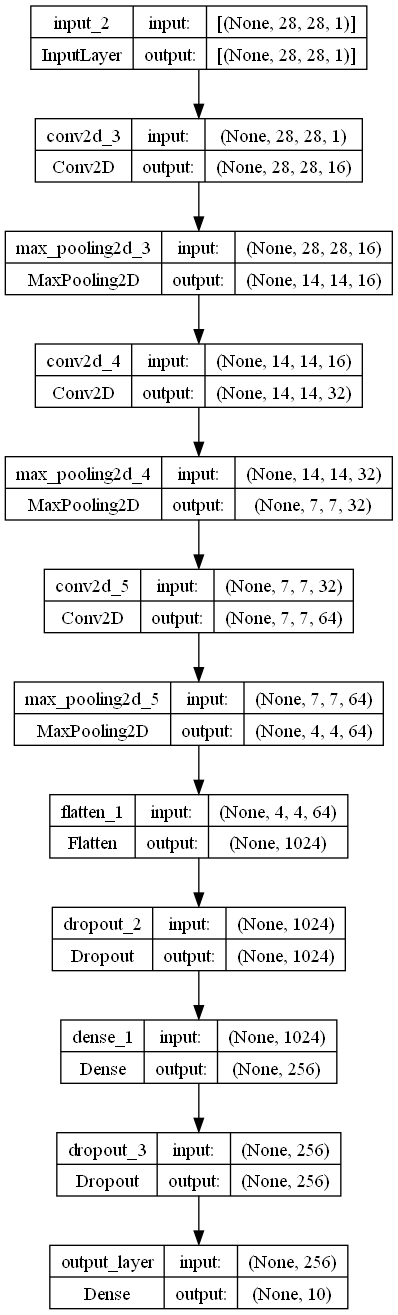

In [26]:
keras.utils.plot_model(model, show_shapes=True)

##### 학습
###### Dense layer만 사용한것에 비해 1ecpoch도는 시간이 길다
why?
- Dense layer는 내적이므로 한번에 계산하지만 Convolution Layer는 filter의 channel의 개수를 하나씩 계산하기 때문에 계산량이 많아 속도가 느릴 수 밖에 없다.

In [30]:
hist = model.fit(train_dataset, 
                 epochs=N_EPOCH, 
                 validation_data=test_dataset)

60/60 [==============================] - 13s 194ms/step - loss: 0.7563 - accuracy: 0.7707 - val_loss: 0.1377 - val_accuracy: 0.9567


##### 결과시각화

In [31]:
hist.history

{'loss': [0.7563372254371643],
 'accuracy': [0.7707499861717224],
 'val_loss': [0.13771158456802368],
 'val_accuracy': [0.9567000269889832]}

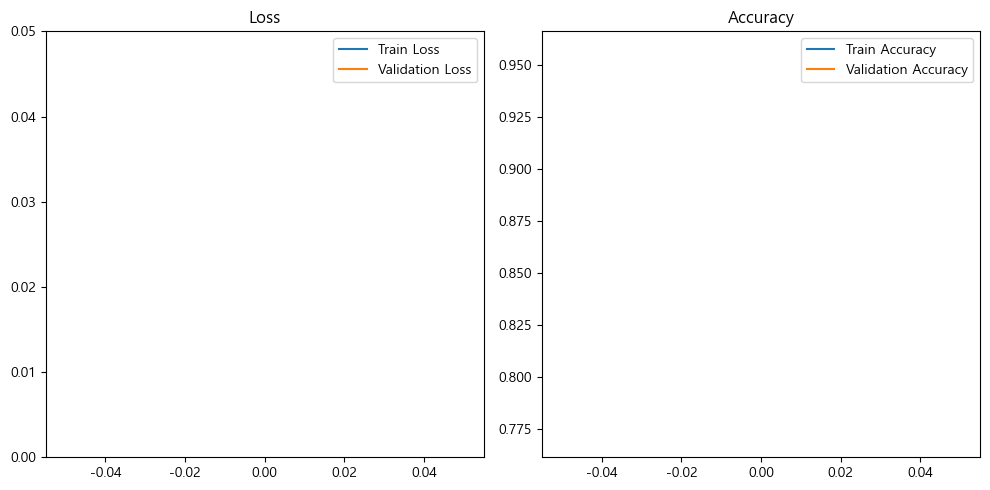

In [32]:
plot_result(hist, 0, 0.05)

##### 최종검증

In [33]:
loss, acc = model.evaluate(test_dataset)
print(f"최종평가 결과: loss-{loss}, accuracy-{acc}")

10/10 [==============================] - 0s 46ms/step - loss: 0.1377 - accuracy: 0.9567
최종평가 결과: loss-0.13771158456802368, accuracy-0.9567000269889832


## prediction error가 발생한 data 확인
- test dataset으로 예측한 결과중 틀린 것들을 확인해 본다.

In [36]:
pred = model.predict(X_test) # 추론 -> 입력: X
pred.shape

313/313 [==============================] - 2s 6ms/step


(10000, 10)

In [37]:
label = np.argmax(pred, axis=-1)
print(label.shape)

(10000,)


In [38]:
pred[0]

array([1.3147070e-07, 3.9809166e-08, 1.8312285e-05, 3.3478544e-05,
       1.6446874e-10, 5.1455487e-07, 2.6983546e-11, 9.9992049e-01,
       4.5184311e-06, 2.2437496e-05], dtype=float32)

In [40]:
label[0]

7

In [41]:
np.where(test_label  != label)

(array([  18,   33,   61,   73,  151,  217,  241,  247,  259,  290,  320,
         321,  340,  403,  406,  435,  445,  448,  479,  495,  507,  551,
         553,  571,  572,  578,  582,  591,  605,  613,  619,  628,  659,
         684,  689,  691,  717,  720,  740,  810,  844,  872,  894,  898,
         924,  939,  947,  956,  960,  965, 1003, 1014, 1039, 1062, 1068,
        1101, 1107, 1112, 1114, 1119, 1125, 1156, 1173, 1181, 1191, 1208,
        1226, 1228, 1232, 1247, 1283, 1289, 1299, 1326, 1364, 1393, 1453,
        1522, 1527, 1530, 1549, 1553, 1559, 1569, 1581, 1621, 1634, 1637,
        1678, 1681, 1709, 1717, 1721, 1737, 1754, 1790, 1813, 1850, 1868,
        1878, 1901, 1952, 1955, 1956, 1982, 1984, 2016, 2024, 2043, 2044,
        2052, 2053, 2070, 2093, 2098, 2109, 2118, 2129, 2130, 2135, 2148,
        2162, 2168, 2182, 2185, 2186, 2189, 2224, 2266, 2272, 2280, 2293,
        2299, 2325, 2358, 2371, 2380, 2381, 2382, 2387, 2393, 2395, 2406,
        2408, 2422, 2447, 2450, 2454, 

In [45]:
# 모델이 추론한 결과중 정답과 다른 것의 index를 조회
fail_idx = np.where(test_label  != label)[0]
fail_idx.size

433

In [47]:
433/10000 # 전체 중 틀린 확률 100-0.0433 = 맞은 확률

0.0433

##### confusion matrix 확인

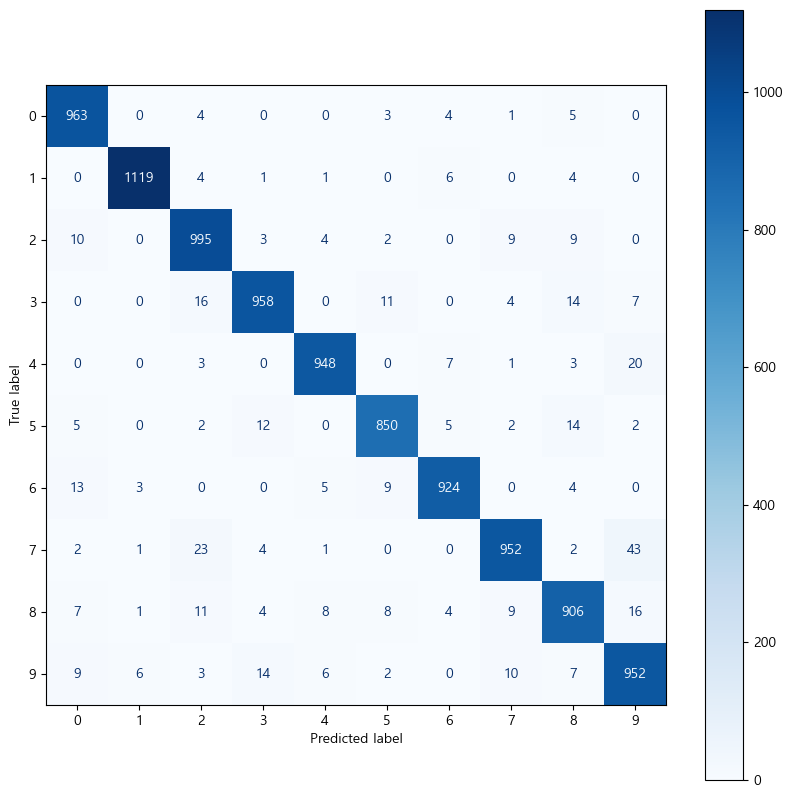

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(10,10))
ax = plt.gca()

cm = confusion_matrix(test_label, label) # (정답라벨, 모델추정라벨)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap="Blues", ax=ax)
plt.show
# 대각선이 맞은것

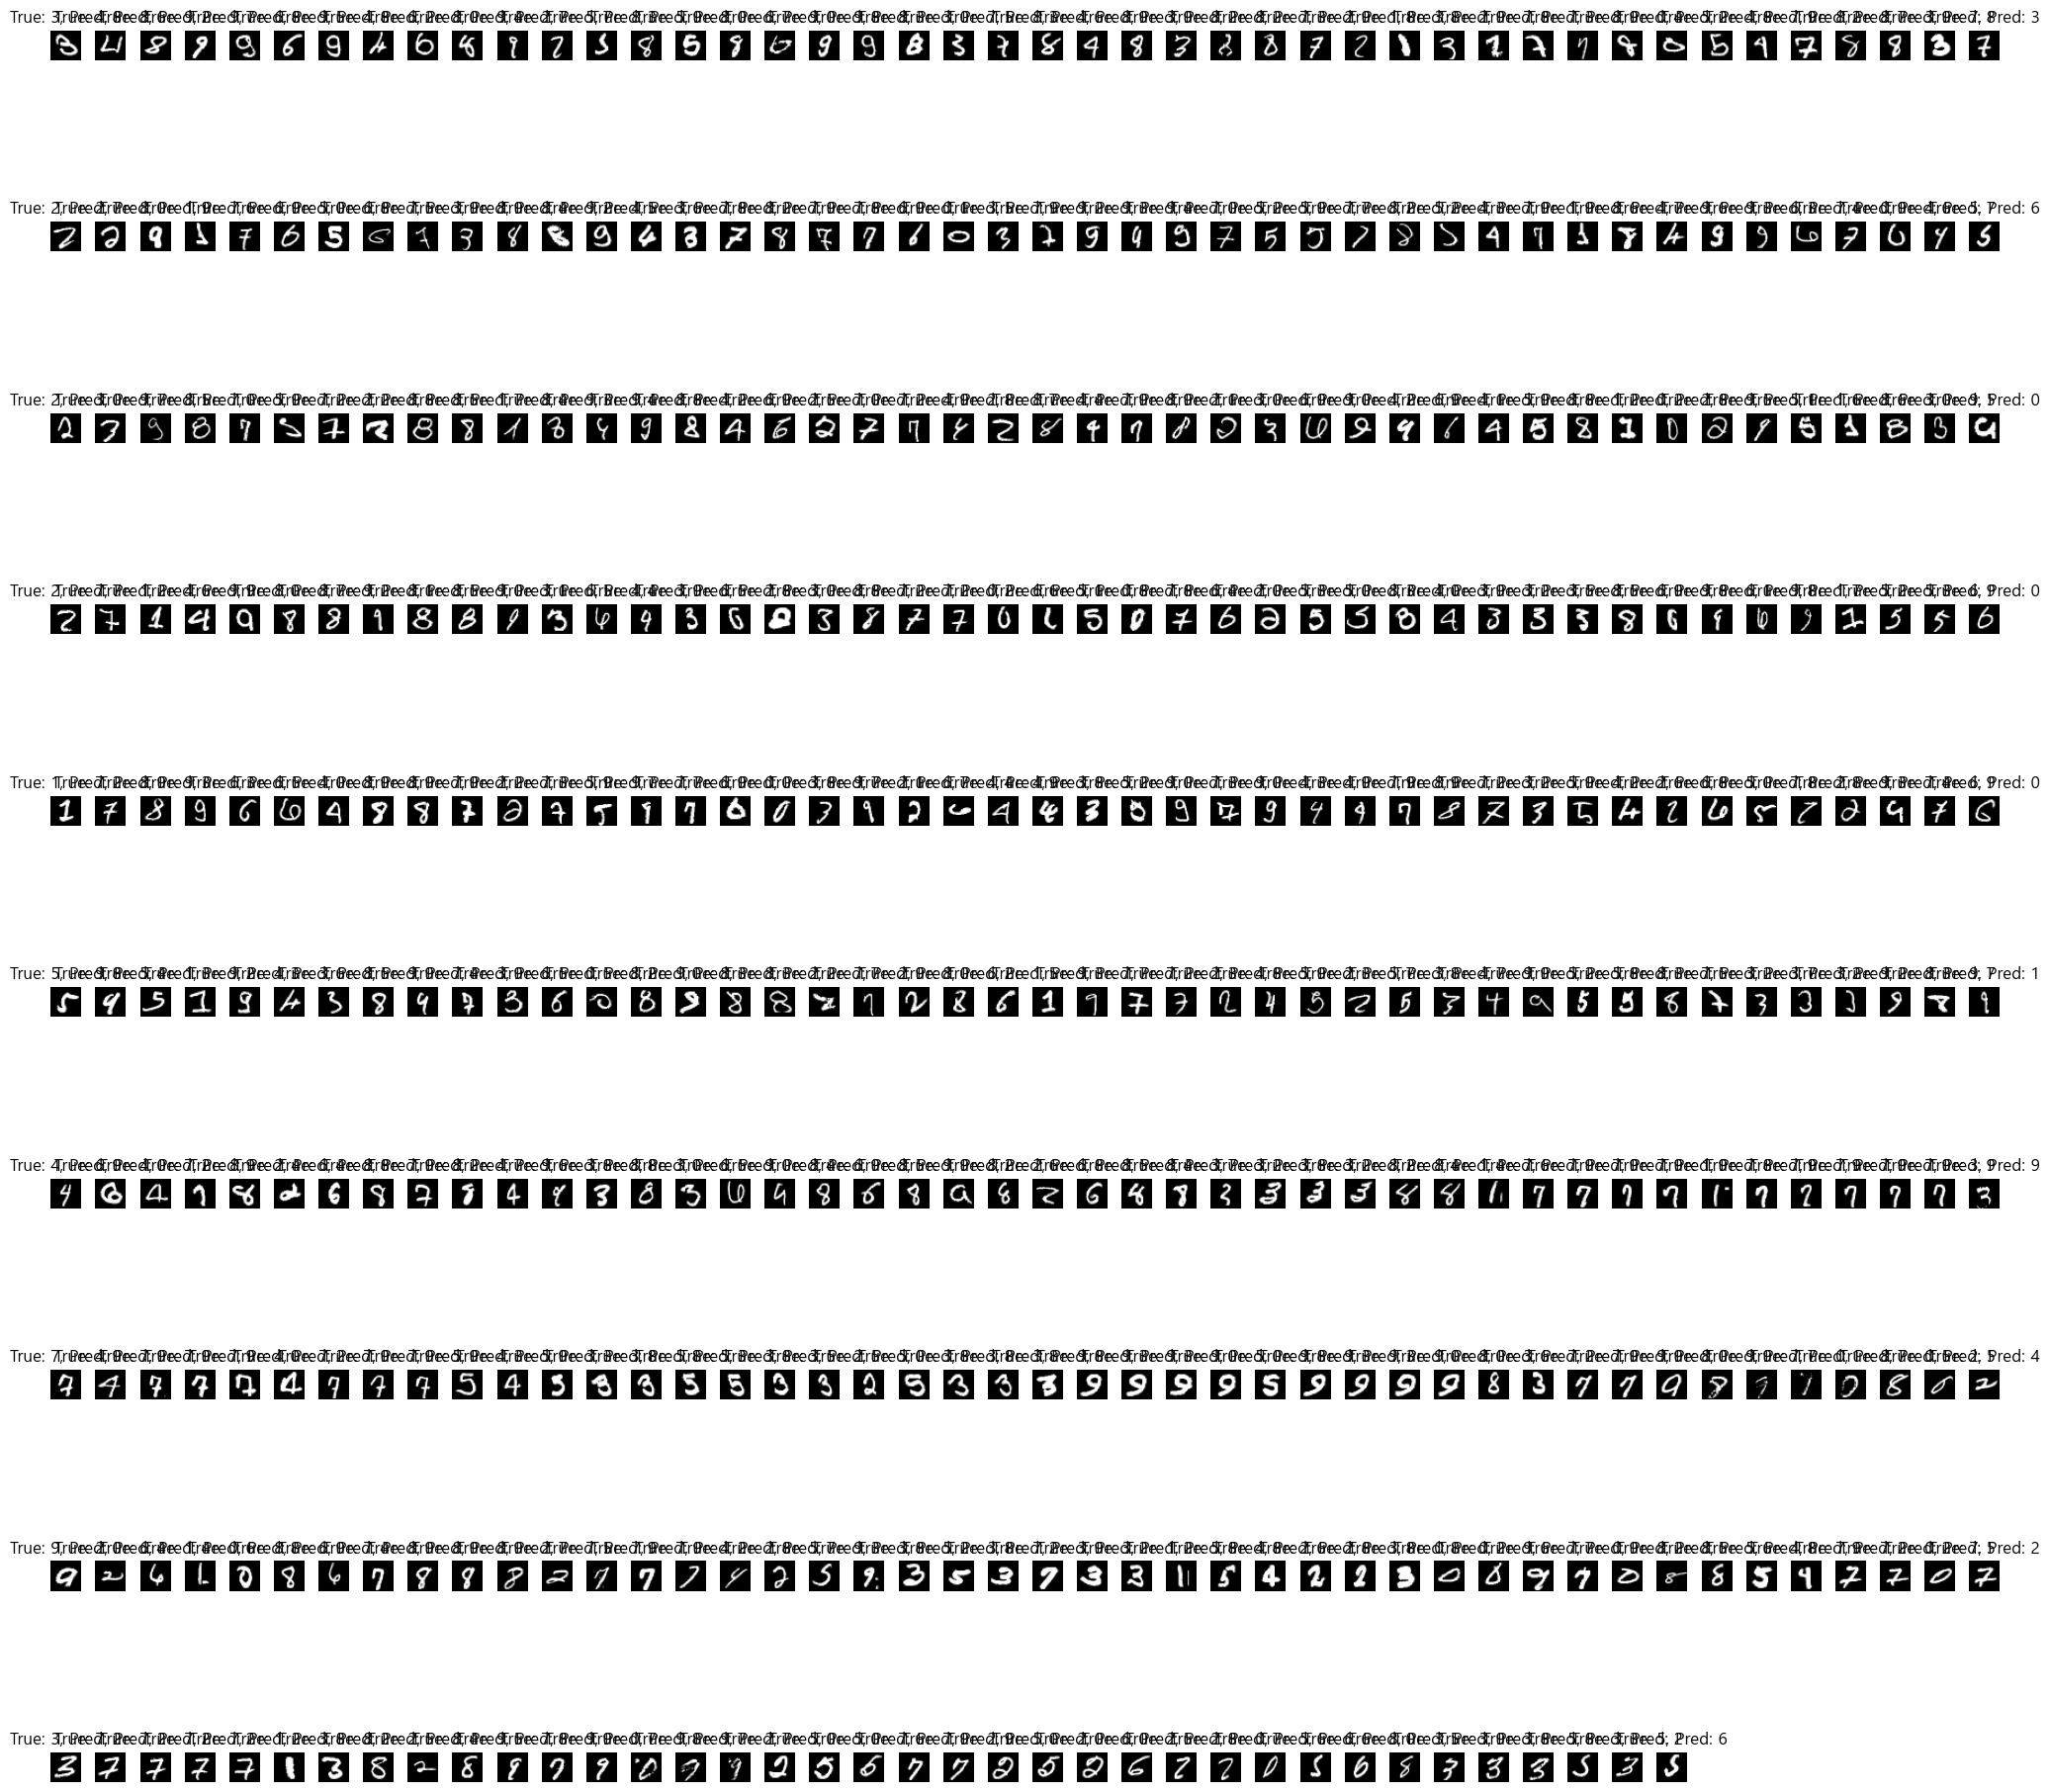

In [48]:
# 틀린 이미지들 중 일부 시각화
plt.figure(figsize=(20, 20))
rows = int(np.ceil(fail_idx.size/10))

for i in range(int(fail_idx.size)):
    error_idx = fail_idx[i] # fail_index > 틀린 index들의 배열. index하나를 조회
    pred_label = label[error_idx] # 모델이 추정한 값
    true_label = test_label[error_idx] # 정답
    img = test_image[error_idx] # 틀리 index의 이미지

    plt.subplot(10, rows, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## 최종평가

In [ ]:
# 지워도 됨
# saved_model.evaluate(test_dataset)

# 딥러닝 모델 저장

- **무엇을 저장할 지**
    1. Train이 끝난 모델의 파라미터만 저장할 수 도 있고,
    1. 모델 구조와 파라미터 모두 저장할 수 도 있다.

- **저장시점**
    1. Train 완료된 모델을 저장
    1. Callback을 이용해 Train 도중 가장 성능이 좋은 시점의 모델을 저장

## 텐서플로 저장 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 타입

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장
    - `model.save_weights("저장경로")`
- 불러오기
    - 새로 생성한 모델의 초기파라미터를 저장한 파라미터로 덮어씌운다. (load)
    - `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`
        - 또는 파일 확장자를 h5로 지정한다.

In [49]:
# 저장할 디렉토리 생성
import os
# SAVE_ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks"
SAVE_ROOT_PATH = "C:\\classes"
SAVE_MODEL_PATH = os.path.join(SAVE_ROOT_PATH, 'saved_models')
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
print(os.path.isdir(SAVE_MODEL_PATH)) # 디렉토리인지 여부 (False: 파일이거나 없거나)

True


In [51]:
# MODEL의 파라미터들만 저장. => model.save_weight(저장파일경로)
MNIST_WEIGHTS_DIR_PATH = os.path.join(SAVE_MODEL_PATH, 'mnist_cnn_weights')
os.makedirs(MNIST_WEIGHTS_DIR_PATH, exist_ok=True)
# 저장할 파일의 경로
MNIST_WEIGHTS_FILE_PATH = os.path.join(MNIST_WEIGHTS_DIR_PATH, 'ckpt')

In [52]:
MNIST_WEIGHTS_FILE_PATH 

'C:\\classes\\saved_models\\mnist_cnn_weights\\ckpt'

In [53]:
model.save_weights(MNIST_WEIGHTS_FILE_PATH)

In [54]:
# 저장된 WEIGHT를 LOADING해서 모델을 RESTORE
# 1. 모델을 생성
saved_model2 = get_mnist_cnn_model(LEARNING_RATE)
saved_model2.evaluate(test_dataset)

10/10 [==============================] - 1s 58ms/step - loss: 2.3052 - accuracy: 0.0748


[2.305156707763672, 0.07479999959468842]

In [55]:
#2. 생성한 모델에 읽어온(loading) weight를 덮어씌운다.
saved_model2.load_weights(MNIST_WEIGHTS_FILE_PATH)
saved_model2.evaluate(test_dataset)

10/10 [==============================] - 1s 53ms/step - loss: 0.1377 - accuracy: 0.9567


[0.13771158456802368, 0.9567000269889832]

## 전체 모델 저장하고 불러오기
- https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko
- 저장
    - `model.save('저장할디렉토리')`
        - 저장할 파일경로가 아니라 **디렉토리 경로를** 지정한다.
- 불러오기
    - `tf.keras.models.load_model('저장된디렉토리')`
- 저장 형식
    - Tensorflow **SavedModel** 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 
        - 또는 파일의 확장자를 h5로 지정한다.

In [59]:
SAVE_MODEL_PATH

'C:\\classes\\saved_models'

In [60]:
MNIST_MODEL_PATH = os.path.join(SAVE_MODEL_PATH, 'mnist_cnn_model') 

In [62]:
model.save(MNIST_MODEL_PATH)

INFO:tensorflow:Assets written to: C:\classes\saved_models\mnist_cnn_model\assets


INFO:tensorflow:Assets written to: C:\classes\saved_models\mnist_cnn_model\assets


In [63]:
saved_model3 = tf.keras.models.load_model(MNIST_MODEL_PATH)
saved_model3.evaluate(test_dataset)

10/10 [==============================] - 1s 53ms/step - loss: 0.1377 - accuracy: 0.9567


[0.13771158456802368, 0.9567000269889832]

In [64]:
# 위는 다 끝나고 저장
# callback은 학습도중에 모델 저장

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- Keras는 학습하는 도중 호출되는 다양한 콜백 클래스들을 제공한다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- ### ModelCheckpoint
    - 각 epoch 마다 학습한 모델과 weight(또는 weight만)를 저장한다. 
    - 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight만 저장할 수 있다.
    - 주요 파라미터
        - `save_weights_only=True`: True: 파라미터(weight)만 저장한다. False: 모델구조와 파라미터 모두 저장한다.
        - `save_best_only=True`: 학습중 성능이 개선될 때만 저장한다. (False:기본값 - 모든 에폭마다 저장한다.)
- ### EarlyStopping
    - Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈추는 callback
    - 주요 파라미터
        - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
        - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 

- **callback 객체들을 리스트로 묶은 뒤 fit()의 callbacks 매개변수에 전달한다.**

In [ ]:
#  모델생성
model2 = get_mnist_cnn_model(LEARNING_RATE)

In [ ]:
# CALLBACK 

SAVE_MODEL_PATH = "/content/drive/MyDrive/SAVED_MODELS"

# 저장할 경로에 {epoch} => 몇번째 에폭에서 저장하는지를 넣어준다.
#     {epoch:04d} 04d - 자릿수를 4자리로 맞춘다. 모자라는 것은 0으로 채운다.
# MNIST_MODEL_CALLBACK_0001
# MNIST_MODEL_CALLBACK_0002
# MNIST_MODEL_CALLBACK_0010


#### save_best_only=True: 가장 좋은 성능의 모델만 저장하겠다는 것이므로
#### epoch을 넣어서 저장경로를 만들지 않는다.
SAVE_PATH = os.path.join(SAVE_MODEL_PATH, 'MNIST_MODEL_CALLBACK_{epoch:04d}')

# 학습 도중 한 에폭이 끝나면 모델을 저장.
mc_callback = keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH, # 저장할 경로
                                              save_best_only=True, #  성능이 개선되면 저장. - 이게 없으면 매 에폭마다 저장하게된다.
                                              monitor='val_loss', # 확인할 성능지표
                                              verbose=1 # 저장시 로그출력
                                              )

# 성능이 개선되지 않으면 지정한 에폭이 안됬어도 중간에 종료시키는 콜백.
# val_loss가 5에폭동안 개선되지 않으면 조기종료.
early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    verbose=1
                                                    )

hist = model2.fit(train_dataset, epochs=100, validation_data=test_dataset, 
                  callbacks=[mc_callback, early_stop_callback])

In [ ]:
# 저장된 모델을 loading
saved_model4 = models.load_model("/content/drive/MyDrive/SAVED_MODELS/MNIST_MODEL_CALLBACK_0021")
saved_model4.evaluate(test_dataset)



In [ ]:
# weight 만 저장하도록 callback 설정
model4 = get_mnist_cnn_model(LEARNING_RATE)

SAVE_PATH = os.path.join(SAVE_MODEL_PATH, 'MNIST_WEIGHTS_CALLBACK/ckpt')# ckpt만 쓰면 개선될때마다 덮어 씌워진다. 각자 저장하려면 ckpt{}
mc_callback = keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH,
                                              save_best_only=True, # True이어야 성능이 개선될때만 저장된다.
                                              monitor='val_loss',
                                              verbose=1,
                                              save_weights_only=True, # 파라티터만 저장해라.
                                              )

early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    verbose=1
                                                    )

hist = model4.fit(train_dataset, epochs=100, validation_data=test_dataset,
                  callbacks=[mc_callback, early_stop_callback])

In [ ]:
# 1. 모델 생성
saved_model5 = get_mnist_cnn_model(LEARNING_RATE)
# 2. 생성된 모델에 저장된 파라미터를 loading(덮어씌우기)
saved_model5.load_weights(SAVE_PATH)

In [ ]:
saved_model5.evaluate(test_dataset)